# Logistic Regression - Spark ML

### data: 성별 소득 data 에 따라 특정 구매자의 구매할지 여부를 예측

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("SparkML") \
             .config("spark.sql.repl.eagerEval.enabled", True) \
             .getOrCreate()
spark

In [4]:
df = spark.read.csv("/content/Social_Network_Ads.csv", header="true", inferSchema="true")
df.limit(5)

User ID,Gender,Age,EstimatedSalary,Purchased
15624510,Male,19,19000,0
15810944,Male,35,20000,0
15668575,Female,26,43000,0
15603246,Female,27,57000,0
15804002,Male,19,76000,0


In [5]:
## dataset size
df.count()

400

In [6]:
## target 변수의 cardinality check
df.groupBy('Purchased').count().show()

+---------+-----+
|Purchased|count|
+---------+-----+
|        1|  143|
|        0|  257|
+---------+-----+



In [7]:
# Spark 데이터프레임의 스키마(schema)
df.printSchema()

root
 |-- User ID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- EstimatedSalary: integer (nullable = true)
 |-- Purchased: integer (nullable = true)



In [8]:
# 데이터프레임에서 특정 컬럼("Age", "EstimatedSalary")을 선택한 후, 요약 통계 출력
df.select(["Age", "EstimatedSalary"]).describe()

summary,Age,EstimatedSalary
count,400,400
mean,37.655,69742.5
stddev,10.482876597307927,34096.9602824248
min,18,15000
max,60,150000


### 문자열을 One-Hot 벡터로 변환
- `Gender` 컬럼이 범주형이므로 one hot encoding

In [9]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

# 범주형 데이터를 숫자형 인덱스로 변환
indexer = StringIndexer(inputCol="Gender", outputCol="Gender_").fit(df)
df_r = indexer.transform(df)

df_r.limit(5)

User ID,Gender,Age,EstimatedSalary,Purchased,Gender_
15624510,Male,19,19000,0,1.0
15810944,Male,35,20000,0,1.0
15668575,Female,26,43000,0,0.0
15603246,Female,27,57000,0,0.0
15804002,Male,19,76000,0,1.0


In [10]:
# 범주형 데이터를 숫자로 변환한 후, 이를 원-핫 인코딩 형식으로 변환
ohe_encoder = OneHotEncoder(inputCols=['Gender_'], outputCols=['Gender_ohe']).fit(df_r)
df_r = ohe_encoder.transform(df_r)

df_r.limit(5)

User ID,Gender,Age,EstimatedSalary,Purchased,Gender_,Gender_ohe
15624510,Male,19,19000,0,1.0,"(1,[],[])"
15810944,Male,35,20000,0,1.0,"(1,[],[])"
15668575,Female,26,43000,0,0.0,"(1,[0],[1.0])"
15603246,Female,27,57000,0,0.0,"(1,[0],[1.0])"
15804002,Male,19,76000,0,1.0,"(1,[],[])"


In [11]:
from pyspark.ml.feature import VectorAssembler

# 여러 개의 입력 컬럼을 하나의 벡터로 결합하여 머신러닝 모델에서 사용할 수 있는 형식으로 변환
assembler = VectorAssembler(
    inputCols=['Age', 'EstimatedSalary', 'Gender_ohe'],
    outputCol='features'
)

output = assembler.transform(df_r)
output.limit(5)


User ID,Gender,Age,EstimatedSalary,Purchased,Gender_,Gender_ohe,features
15624510,Male,19,19000,0,1.0,"(1,[],[])","[19.0,19000.0,0.0]"
15810944,Male,35,20000,0,1.0,"(1,[],[])","[35.0,20000.0,0.0]"
15668575,Female,26,43000,0,0.0,"(1,[0],[1.0])","[26.0,43000.0,1.0]"
15603246,Female,27,57000,0,0.0,"(1,[0],[1.0])","[27.0,57000.0,1.0]"
15804002,Male,19,76000,0,1.0,"(1,[],[])","[19.0,76000.0,0.0]"


In [12]:
from pyspark.ml.feature import StandardScaler

# 데이터를 표준화(Standardization)하여 평균이 0이고, 분산이 1이 되도록 변환
scaler = StandardScaler(inputCol='features', outputCol='standardized')

data_scaled = scaler.fit(output).transform(output)
data_scaled.limit(5)

User ID,Gender,Age,EstimatedSalary,Purchased,Gender_,Gender_ohe,features,standardized
15624510,Male,19,19000,0,1.0,"(1,[],[])","[19.0,19000.0,0.0]",[1.81247960172299...
15810944,Male,35,20000,0,1.0,"(1,[],[])","[35.0,20000.0,0.0]",[3.33877821370025...
15668575,Female,26,43000,0,0.0,"(1,[0],[1.0])","[26.0,43000.0,1.0]",[2.48023524446304...
15603246,Female,27,57000,0,0.0,"(1,[0],[1.0])","[27.0,57000.0,1.0]",[2.57562890771162...
15804002,Male,19,76000,0,1.0,"(1,[],[])","[19.0,76000.0,0.0]",[1.81247960172299...


In [13]:
# 표준화된 데이터와 타겟 변수를 선택하여 새로운 데이터프레임 생성
# - select: 특정 컬럼("standardized", "Purchased")만 선택
# - "standardized": 표준화된 특징 벡터 컬럼
# - "Purchased": 타겟 변수 컬럼
data = data_scaled.select("standardized", "Purchased")

data.show(5, truncate=False)

+----------------------------------------------------------+---------+
|standardized                                              |Purchased|
+----------------------------------------------------------+---------+
|[1.8124796017229972,0.5572344233217031,0.0]               |0        |
|[3.338778213700258,0.5865625508649507,0.0]                |0        |
|[2.480235244463049,1.261109484359644,1.9978980551207968]  |0        |
|[2.5756289077116277,1.6717032699651093,1.9978980551207968]|0        |
|[1.8124796017229972,2.2289376932868126,0.0]               |0        |
+----------------------------------------------------------+---------+
only showing top 5 rows



In [14]:
# 데이터를 학습용(train)과 테스트용(test)으로 랜덤하게 분할
train_data, test_data = data.randomSplit([0.75, 0.25])

train_data.count(), test_data.count()

(285, 115)

In [15]:
from pyspark.ml.classification import LogisticRegression

# 로지스틱 회귀(Logistic Regression) 모델을 생성하고 학습
log_reg = LogisticRegression(featuresCol="standardized", labelCol="Purchased").fit(train_data)
log_reg

LogisticRegressionModel: uid=LogisticRegression_43545403fc4d, numClasses=2, numFeatures=3

In [16]:
# 학습된 로지스틱 회귀 모델(log_reg)을 사용하여 테스트 데이터(test_data)에 대한 예측 수행
# 결과에는 원본 데이터와 함께 예측 확률(probability), 예측 레이블(prediction), 그리고 각 클래스별 확률이 포함됩니다.
pred = log_reg.transform(test_data)
pred.show(5, truncate=False)

+----------------------------------------------------------+---------+----------------------------------------+------------------------------------------+----------+
|standardized                                              |Purchased|rawPrediction                           |probability                               |prediction|
+----------------------------------------------------------+---------+----------------------------------------+------------------------------------------+----------+
|[1.7170859384744184,1.5250626322488718,0.0]               |0        |[6.078450019359277,-6.078450019359277]  |[0.9977135139671036,0.0022864860328963843]|0.0       |
|[1.7170859384744184,1.9943126729408323,1.9978980551207968]|0        |[6.0556576478479425,-6.0556576478479425]|[0.9976609243835741,0.0023390756164258786]|0.0       |
|[1.7170859384744184,2.522218968719288,1.9978980551207968] |0        |[5.289054130376265,-5.289054130376265]  |[0.994978808238073,0.005021191761926946]  |0.0       |
|[1.

In [17]:
pred.first()

Row(standardized=DenseVector([1.7171, 1.5251, 0.0]), Purchased=0, rawPrediction=DenseVector([6.0785, -6.0785]), probability=DenseVector([0.9977, 0.0023]), prediction=0.0)

In [18]:
# 예측 결과(prediction)를 기준으로 그룹화하여 각 예측 클래스별 개수 계산
pred.groupBy('prediction').count().orderBy('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|   82|
|       1.0|   33|
+----------+-----+



In [19]:
# 실제 값(Purchased)을 기준으로 그룹화하여 각 클래스별 데이터 개수 계산
pred.groupBy('Purchased').count().orderBy('Purchased').show()

+---------+-----+
|Purchased|count|
+---------+-----+
|        0|   71|
|        1|   44|
+---------+-----+



### Confustion Matrix 시각화

0.782608695652174
[[64  7]
 [18 26]]


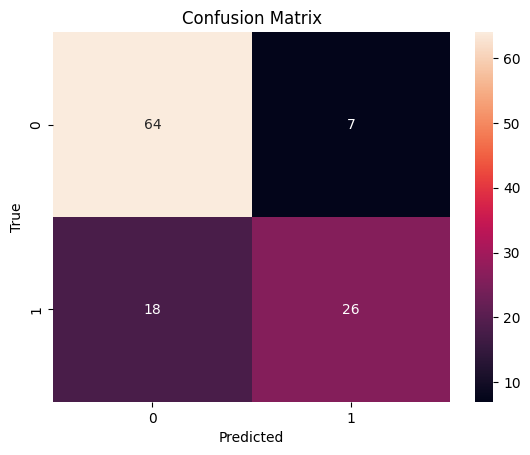

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns

# 예측 결과(pred)에서 실제 값과 예측 값을 리스트로 변환
y_true = pred.select("Purchased").collect()  # 실제 값
y_pred = pred.select("prediction").collect()  # 예측 값

# 혼동 행렬(Confusion Matrix) 계산
cm = confusion_matrix(y_true, y_pred)

# 정확도(Accuracy) 계산
accuracy = accuracy_score(y_true, y_pred)

# 정확도 및 혼동 행렬 출력
print(accuracy)
print(cm)

# 혼동 행렬을 히트맵으로 시각화
ax = sns.heatmap(cm, annot=True, fmt='d')
ax.set_title("Confusion Matrix")  # 히트맵 제목 설정
ax.set_xlabel("Predicted")        # x축 레이블 (예측값)
ax.set_ylabel("True")             # y축 레이블 (실제값)
None